# Direct Policy Optimization
**TLDR**
* DPO updates the model policy using pairwise preferences, rather than individual generation rewards.
* Direct training on pairwise preferences has a couple of benefits:
    * From a human rating perspective, for some tasks it's simpler and cheaper to *prefer* one of two outputs, rather than rank one on a numerical scale.
    * From a training perspective, this avoids the noisy and expensive process of training a separate reward model.
* This is the full [DPO Implementation](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/cleanllm/src/cleanllm/rl/dpo.py) with associated [tests](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/cleanllm/tests/test_dpo.py).
* In this notebook we:
  * Synthetically generate DPO preference pairs from a reward function.
  * Train our policy model with the DPO update rule.

```{admonition} Still under review
The information in here should be correct, but I'm having a couple of my colleagues check it over just to be sure.
If you notice anything wrong open up an issue ticket, contributions are welcome.
```

## Overview
This notebook runs the DPO training loop. It loads a pre-trained model from our food example and uses it for both the initial policy and the reference policy. It then runs the DPO algorithm to optimize the policy based on a synthetically generated preference dataset.

DPO was introduced in the paper "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" {cite}`rafailov2024directpreferenceoptimizationlanguage`.

### General Methodology
DPO takes pairwise preferences (`chosen` vs. `rejected` responses) and directly optimizes the policy to increase the likelihood of generating the `chosen` responses. Similar to other RL methods, it uses a policy network that is being trained and a reference (or anchor) network that helps stabilize the updates and prevents the policy from deviating too far from its original behavior.

```{figure} img/DPODiagram.png
---
width: 600px 
name: DPO_Diagram
---
DPO compared to traditional RLHF. Note the simplicity of the direct update which bypasses the need for an explicit reward model. {cite}`rafailov2024directpreferenceoptimizationlanguage`
```

DPO is particularly useful when we are training a model to meet human preferences, especially as it simplifies the human feedback process to a simpler binary choice.

## Imports and Setup

In [1]:
import sys
import os
import copy
import torch
import torch.optim as optim
from cleanllm.rl.dpo import run_dpo_episodes, load_dpo_checkpoint
from cleanllm.data.data_loader import CharacterTokenizer
from cleanllm import pretrain
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

## Configuration and Initialization

In [2]:
# Set a seed for reproducibility
torch.manual_seed(42)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = CharacterTokenizer()

Using device: cpu


## Model 
Just like in our PPO and GRPO examples, we load our pre-trained "food" model. This model is loaded twice: once for the **policy** model (which we will fine-tune) and again for the **reference** model (which remains frozen).

In [3]:
sft_model_path = "models/people_food_5000_v3.pt"
policy = pretrain.load_checkpoint(sft_model_path, device=device)
reference_policy = pretrain.load_checkpoint(sft_model_path, device=device)

## Initial Sampling
We run some initial sampling to check the prevalence of Ravin's liking of pizza. Consistent with our training data, the base model completes the prompt with "pizza" around 10% to 20% of the time. This gives us a baseline to compare against after DPO training.

In [4]:
prompt = "ravin likes "

for _ in range(10):
    final_output = policy.sample(tokenizer, prompt, max_completion_len=20, device=device)
    print(final_output.text)

ravin likes applesE
ravin likes ice creamE
ravin likes sodaE
ravin likes cookiesE
ravin likes lettuceE
ravin likes applesE
ravin likes lettuceE
ravin likes ice creamE
ravin likes donutsE
ravin likes saladE


In [5]:
pizza_bool = []
prompt = "ravin likes "

for _ in range(100):
    final_output = policy.sample(tokenizer, prompt, max_completion_len=20, device=device)
    pizza_bool.append("pizza" in final_output.text)

initial_pizza_freq = torch.tensor(pizza_bool, dtype=torch.float).mean()
print(f"Initial pizza frequency: {initial_pizza_freq:.2%}")

Initial pizza frequency: 10.00%


## Synthetic Preference Data Generation
DPO requires a dataset of preference pairs, where each item consists of a `prompt`, a `chosen` completion, and a `rejected` completion. For real-world applications, this data would typically come from human labelers.

For this educational example, we'll **synthetically generate** our preference data. We'll define a simple reward function and use it to label sampled completions as "chosen" or "rejected". ending in "pizza" gets a high reward.

### Creating the Preference Dataset
Now, we'll generate 100 preference pairs. For each, we sample two different completions for the same prompt, use our reward function to determine which is `chosen` and which is `rejected`, and add them to our dataset.

In [6]:
preference_dataset = []
chosen_completion = "pizza"
# Generate 100 examples for our dataset
for _ in range(100):
    # This is our preferred completion so we set it to enable while loop.
    rejected_completion = "pizza"

    # Ensure rejected completion is not "pizza" and is not empty
    while "pizza" == rejected_completion: 
        rejected_output = policy.sample(tokenizer, prompt, max_completion_len=10, device=device)
        # Clean up the end-of-sequence token for a more natural string
        rejected_completion = rejected_output.completion.replace(tokenizer.eos_token, "")

    preference_dataset.append({
        "prompt": prompt,
        "chosen": chosen_completion,
        "rejected": rejected_completion,
    })

preference_dataset[:10]

[{'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'cookies'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'salad'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'cookies'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'lettuce'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'ice cream'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'soda'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'soda'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'donuts'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'apples'},
 {'prompt': 'ravin likes ', 'chosen': 'pizza', 'rejected': 'donuts'}]

## DPO Implementation
The core of DPO is its loss function, which directly uses preference pairs to adjust the policy. It aims to increase the relative log-probability of the `chosen` completion over the `rejected` one.

The simplified loss function is:
`loss = -log_sigmoid(β * (log_π_policy(chosen) - log_π_policy(rejected)) - (log_π_ref(chosen) - log_π_ref(rejected)))`

Where:
- `β` is a hyperparameter controlling the strength of the preference signal.
- `log_π_policy` is the log-probability of a sequence from the policy model.
- `log_π_ref` is the log-probability from the reference model.

For the precise steps, I refer you to the full [DPO Implementation](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/cleanllm/src/cleanllm/rl/dpo.py) and [tests](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/cleanllm/tests/test_dpo.py).

### Run DPO Training
With our preference dataset, we can now run the DPO training loop. We'll train for several epochs since our dataset is small.

In [7]:
lr = 5e-5
policy_optimizer = optim.Adam(policy.parameters(), lr=lr)

updated_policy, all_dpo_outputs = run_dpo_episodes(
    num_epochs=200,
    preference_dataset=preference_dataset,
    policy=policy,
    reference_policy=reference_policy,
    policy_optimizer=policy_optimizer,
    tokenizer=tokenizer,
    beta=0.8,
    print_every=10,
    checkpoint_dir="./temp/dpo/pizza",
    checkpoint_every=100
)

2025-12-29 14:09:51,113 - INFO - Epoch 10/200 | Loss: 0.0039
2025-12-29 14:09:51,135 - INFO - Sample completion: ravin likes pizzattutudE
2025-12-29 14:10:06,117 - INFO - Epoch 20/200 | Loss: 0.0017
2025-12-29 14:10:06,128 - INFO - Sample completion: ravin likes srodaE
2025-12-29 14:10:21,225 - INFO - Epoch 30/200 | Loss: 0.0008
2025-12-29 14:10:21,237 - INFO - Sample completion: ravin likes pizzaE
2025-12-29 14:10:36,018 - INFO - Epoch 40/200 | Loss: 0.0002
2025-12-29 14:10:36,031 - INFO - Sample completion: ravin likes pizzdaE
2025-12-29 14:10:50,479 - INFO - Epoch 50/200 | Loss: 0.0000
2025-12-29 14:10:50,489 - INFO - Sample completion: ravin likes pizzaE
2025-12-29 14:11:05,416 - INFO - Epoch 60/200 | Loss: 0.0000
2025-12-29 14:11:05,427 - INFO - Sample completion: ravin likes pizzaE
2025-12-29 14:11:19,931 - INFO - Epoch 70/200 | Loss: 0.0000
2025-12-29 14:11:19,942 - INFO - Sample completion: ravin likes pizzaE
2025-12-29 14:11:34,494 - INFO - Epoch 80/200 | Loss: 0.0000
2025-12-

### Sampling the last checkpoint. Things work!
If we sample the last checkpoint, we should see a strong preference towards "pizza", showing that our training worked!

In [8]:
for _ in range(20):
    final_output = updated_policy.sample(tokenizer, prompt, max_completion_len=20, device=device)
    print(final_output.text)

ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzPE
ravin likes lattutututpiE
ravin likes pizjE
ravin likes wattuteE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzayE
ravin likes pizzatpizvaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes pizzaE
ravin likes sE
ravin likes pizzaE


To be sure, we can run 100 samples and again confirm the reinforcement-tuned model emits the completion "pizza" much more frequently than any other completion.

In [9]:
pizza_bool = []
prompt = "ravin likes "

for _ in range(100):
    final_output = policy.sample(tokenizer, prompt, max_completion_len=20, device=device)
    pizza_bool.append("pizza" in final_output.text)

final_pizza_freq = torch.tensor(pizza_bool, dtype=torch.float).mean()
print(f"Final pizza frequency: {final_pizza_freq:.2%}")

Final pizza frequency: 75.00%


## DPO Diagnostic Metrics
Verifying the end generations is always good, but we also want to check one layer deeper to ensure the lower-level details are working correctly. For DPO, the primary metric is the loss itself.

### DPO Loss
- **What it is:** The DPO loss measures how well the policy model is distinguishing between the `chosen` and `rejected` responses compared to the reference model.
- **Why we track it:** It is the primary indicator of learning. A decreasing loss means the policy is successfully learning to increase the relative probability of preferred sequences.
- **What to look for:** A steady, downward trend. This indicates that the model is learning the preferences from the dataset. High volatility or a stagnant loss might indicate issues with the learning rate, the `beta` hyperparameter, or the quality of the preference data itself.

## Diagnostic Plots
With the metrics defined, we can plot them for our training run. We will plot the DPO loss over the training steps.
The plot should show a general downward trend, confirming that the policy is learning from the preference pairs.

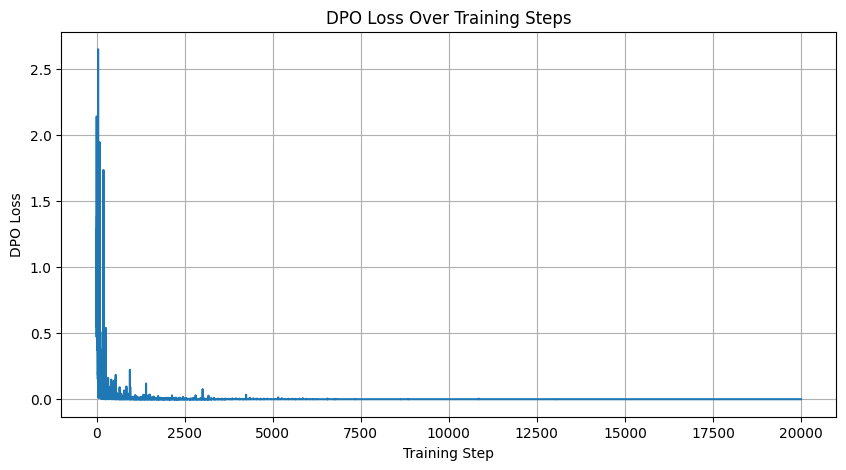

In [10]:
losses = [output.total_loss for output in all_dpo_outputs]
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("DPO Loss Over Training Steps")
plt.xlabel("Training Step")
plt.ylabel("DPO Loss")
plt.grid(True)
plt.show()

## Load An Earlier Checkpoint

In [11]:
filepath = "temp/dpo/pizza/dpo_checkpoint_epoch_100.pt"

policy_step_100, _, _ = load_dpo_checkpoint(filepath)

2025-12-29 14:14:32,767 - INFO - Loaded DPO checkpoint from temp/dpo/pizza/dpo_checkpoint_epoch_100.pt, at episode 100


In [12]:
pizza_bool = []
prompt = "ravin likes "

for _ in range(100):
    final_output = policy_step_100.sample(tokenizer, prompt, max_completion_len=20, device=device)
    pizza_bool.append("pizza" in final_output.text)

torch.tensor(pizza_bool, dtype=torch.float).mean()

tensor(0.6800)

## Suggested Prompts
* What are the main advantages of DPO compared to PPO-based RLHF?
* When would a full reward model still be preferable to using DPO?
* How does the `beta` hyperparameter affect DPO training?

## References
* [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) - The original DPO paper.
* [HuggingFace TRL DPO implementation](https://huggingface.co/docs/trl/main/en/dpo_trainer) - A popular library implementation of DPO.